# Modeling Orographic effect with Linear Diffusion and Stream Power FastScapeEroder 

### Sophie Rothman, Zhiang Chen, Maddie Schwarz

Relationship relating precipitation and elevation: P(z) = P0 + aP0z
  
Initial precipitation rate: P0 = 80mm/yr
   
 a = [1/2.2, 1/1.1]
 
 add equation details
 

In [31]:
# Import necessary Libraries
import os
import matplotlib.pyplot as plt
import numpy as np

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
    LinearDiffuser
)

from landlab.plot import imshow_grid

from PIL import Image
from IPython.display import display
from IPython.display import Image as Img

%matplotlib inline

# 1. Diffusion + StreamPower WITHOUT Orographic Effect

Precipitation does not increase with elevation-- instead related to the mean elevation of the grid

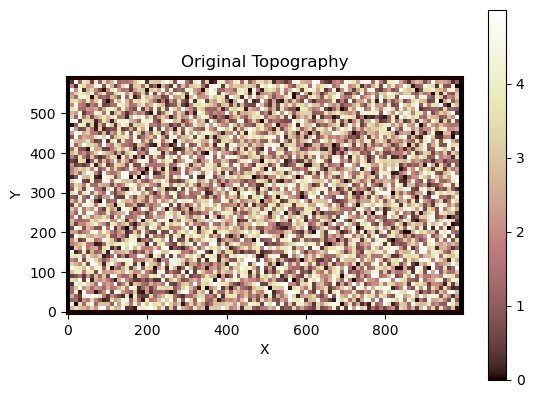

In [36]:
# Create Raster Grid
mg = RasterModelGrid((60, 100), xy_spacing=10)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg.add_zeros("topographic__elevation", at="node")
z[mg.core_nodes] += 0 + np.random.rand(mg.core_nodes.size)*5

imshow_grid(mg,"topographic__elevation", plot_name = "Original Topography")

In [37]:
## Stream Power

dt = 100 # timestep
U = 0.05 # uplift
P0 = 80
a = 1/2.2

U = 0.05 # uplift
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

mg.add_zeros("water__unit_flux_in",at="node")
mg.at_node["water__unit_flux_in"][:] = P0 + a*P0*np.mean(z)

# params for flow accumulator
fr3 = FlowAccumulator(mg, depression_finder="DepressionFinderAndRouter", routing="D4")

sp3 = StreamPowerEroder(
    mg,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Diffusion 
D = (P0 + a*P0*np.mean(z))*0.001 
ld = LinearDiffuser(mg, linear_diffusivity=D)

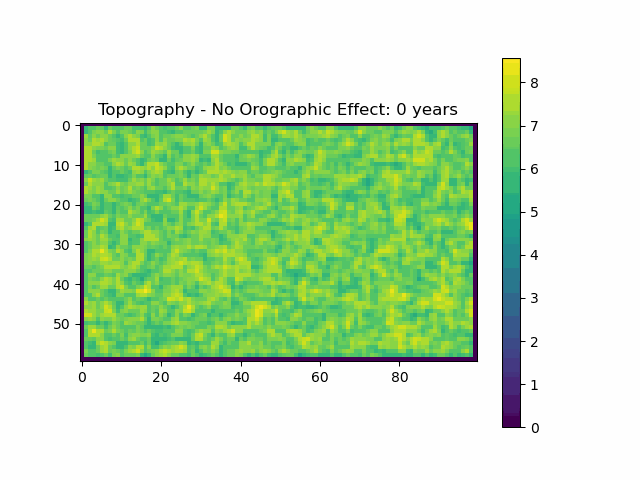

In [38]:
# Run model and Generate GIF
if not os.path.exists('save_fig'):
    os.makedirs('save_fig')
else:
    [os.remove(os.path.join('save_fig',f)) for f in os.listdir('save_fig') if f.endswith('.png')]

frames = []

# Run the model for 30k years:
for i in range(60):
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg.core_nodes] += U * dt
    
    frame = np.flipud(mg.at_node["topographic__elevation"][:].reshape(mg.shape))
    plt.imshow(frame)
    plt.colorbar()
    plt.title("Topography - No Orographic Effect: "+str(dt*i)+" years")
    plt.savefig(f'save_fig/{i}.png')
    plt.close()
    frames.append(Image.open(f'save_fig/{i}.png')) 
    
frames[0].save('Topo_NO_Oro.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

gif_path = 'Topo_NO_Oro.gif'
display(Img(filename=gif_path))

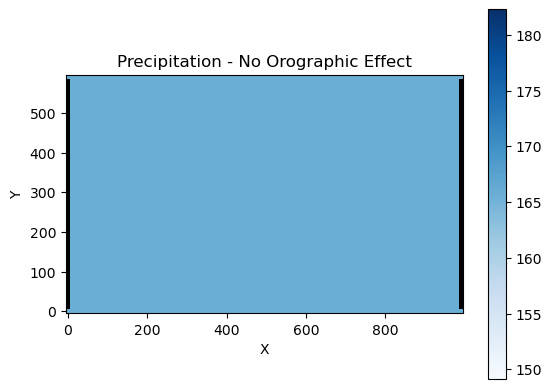

In [35]:
# Plot Precipitation -- without Orographic Effect
imshow_grid(mg,"water__unit_flux_in", cmap="Blues",plot_name = "Precipitation - No Orographic Effect")

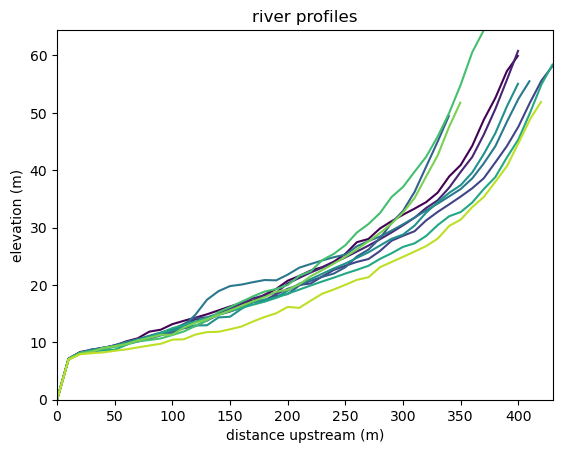

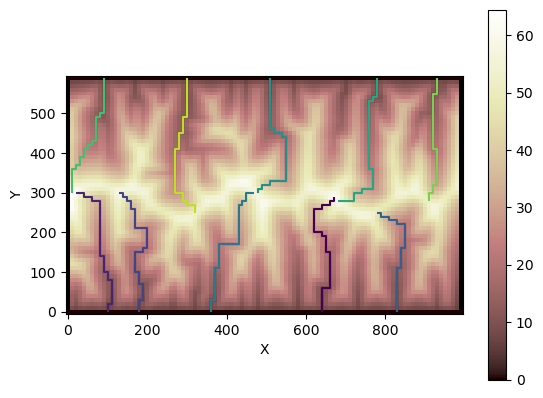

In [10]:
dxy=10

prf = ChannelProfiler(
mg,
number_of_watersheds=10,
main_channel_only=True,
minimum_channel_threshold=dxy**2,
)
prf.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
prf.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
prf.plot_profiles_in_map_view()

# 2. Diffusion + StreamPower WITH Orographic Effect


In [11]:
## Create a Raster Grid
mg2 = RasterModelGrid((60, 100), xy_spacing=10)
mg2.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg2.add_zeros("topographic__elevation", at="node")
z[mg2.core_nodes] += 0 + np.random.rand(mg2.core_nodes.size)*5

In [12]:
## Stream Power Eroder Component

# Fastscape Eroder Model Params
dt = 100 # timestep
P0 = 80
a = 1/2.2
U = 0.05 # uplift
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

# Generate water flux field WITH Orographic effect
mg2.add_zeros("water__unit_flux_in",at="node") 
mg2.at_node["water__unit_flux_in"][:] = P0 + a*P0*z 

# Flow Accumulator Model Params
fr3 = FlowAccumulator(mg2, depression_finder="DepressionFinderAndRouter", routing="D4")
sp3 = StreamPowerEroder(
    mg2,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Linear Diffuser Model Params
D = (P0 + a*P0*z) *0.001
ld = LinearDiffuser(mg2, linear_diffusivity=D)

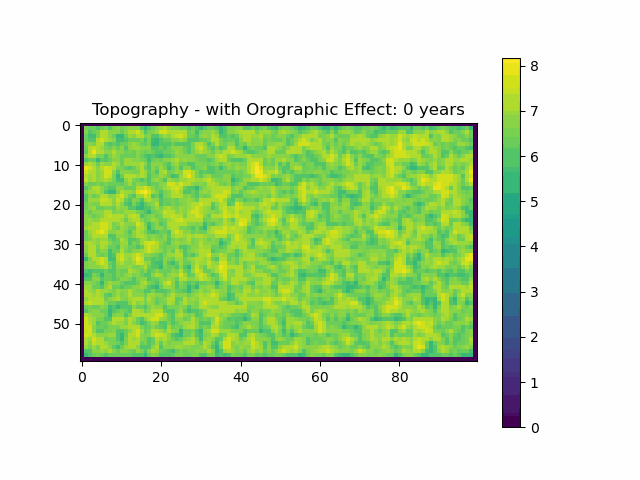

In [13]:
## Run model and Generate GIF
if not os.path.exists('save_fig'):
    os.makedirs('save_fig')
else:
    [os.remove(os.path.join('save_fig',f)) for f in os.listdir('save_fig') if f.endswith('.png')]

frames = []

# Run the model for 30K years
for i in range(60):
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg2.core_nodes] += U * dt
    
    frame = mg2.at_node["topographic__elevation"][:].reshape(mg2.shape)
    plt.imshow(frame)
    plt.colorbar()
    plt.title("Topography - with Orographic Effect: "+str(dt*i)+" years")
    plt.savefig(f'save_fig/{i}.png')
    plt.close()
    frames.append(Image.open(f'save_fig/{i}.png')) 
    
frames[0].save('Topo_Oro.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

gif_path = 'Topo_Oro.gif'
display(Img(filename=gif_path))

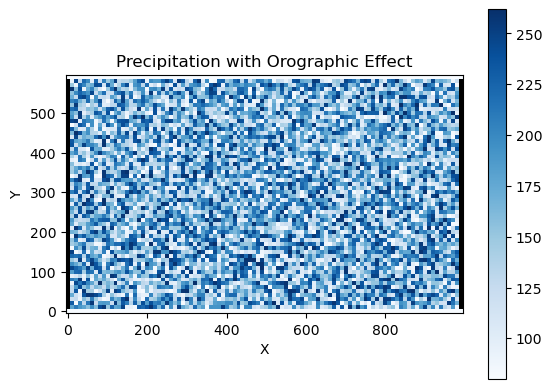

In [14]:
# Plot Precipitation
imshow_grid(mg2,"water__unit_flux_in", cmap="Blues", plot_name = "Precipitation with Orographic Effect")

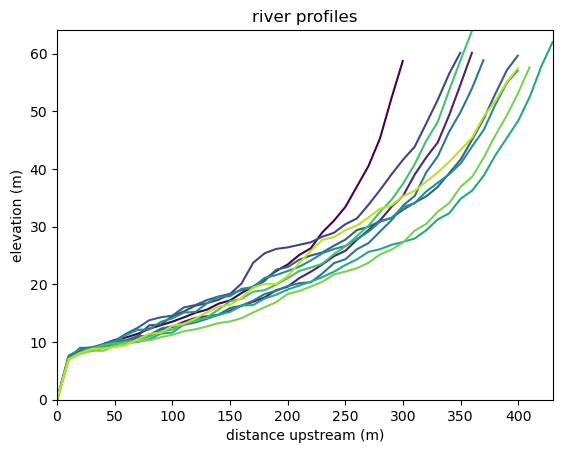

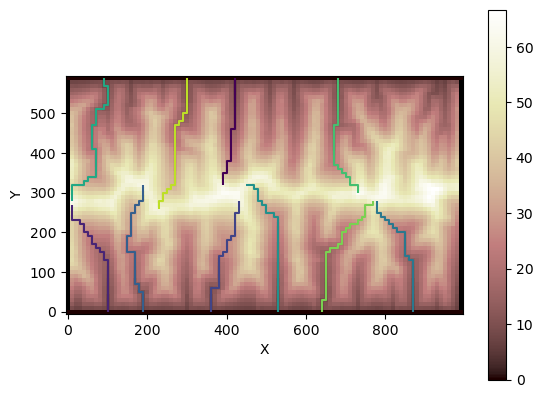

In [15]:
dxy=10

prf = ChannelProfiler(
mg2,
number_of_watersheds=10,
main_channel_only=True,
minimum_channel_threshold=dxy**2,
)
prf.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
prf.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
prf.plot_profiles_in_map_view()

# 3. Influence of Rainshadow WITHOUT Orographic effect

In [21]:
# Create Raster Grid
mg = RasterModelGrid((60, 100), xy_spacing=10)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg.add_zeros("topographic__elevation", at="node")
z[mg.core_nodes] += 0 + np.random.rand(mg.core_nodes.size)*5

In [22]:
## Stream Power

dt = 100 # timestep
U = 0.05 # uplift
P0 = 80
a = 1/2.2

U = 0.05 # uplift
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

mg.add_zeros("water__unit_flux_in",at="node")
mg.at_node["water__unit_flux_in"][:] = P0 + a*P0*np.mean(z)

# params for flow accumulator
fr3 = FlowAccumulator(mg, depression_finder="DepressionFinderAndRouter", routing="D4")

sp3 = StreamPowerEroder(
    mg,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Diffusion 
D = (P0 + a*P0*np.mean(z))*0.001 
ld = LinearDiffuser(mg, linear_diffusivity=D)

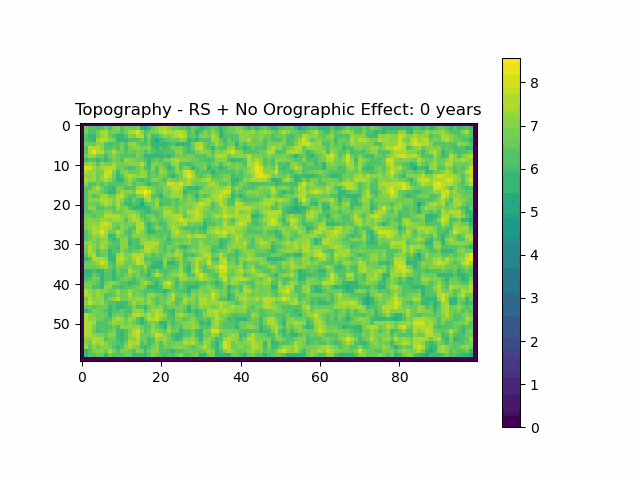

In [23]:
### Has an issue -- GIF is not moving 2:29PM 5/15
# Run model and Generate GIF
if not os.path.exists('save_fig'):
    os.makedirs('save_fig')
else:
    [os.remove(os.path.join('save_fig',f)) for f in os.listdir('save_fig') if f.endswith('.png')]

frames = []
for i in range(60):
    D = (P0 + a*P0*z)*0.0005
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg.core_nodes] += U * dt
    mg.at_node["water__unit_flux_in"][mg.y_of_node>=2+mg.y_of_node[z==max(z)]]=P0/2
    D[mg.y_of_node>=2+mg.y_of_node[z==max(z)]] = (P0/2)*0.001*np.ones(len( D[mg.y_of_node>=10+mg.y_of_node[z==max(z)]]))
    mg.at_node["water__unit_flux_in"][mg.y_of_node<10+mg.y_of_node[z==max(z)]]=P0 + a*P0*z[mg.y_of_node<10+mg.y_of_node[z==max(z)]]
    
    frame = mg.at_node["topographic__elevation"][:].reshape(mg.shape)
    plt.imshow(frame)
    plt.colorbar()
    plt.title("Topography - RS + No Orographic Effect: "+str(dt*i)+" years")
    plt.savefig(f'save_fig/{i}.png')
    plt.close()
    frames.append(Image.open(f'save_fig/{i}.png')) 
    
frames[0].save('Topo_RS.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

gif_path = 'Topo_RS.gif'
display(Img(filename=gif_path))

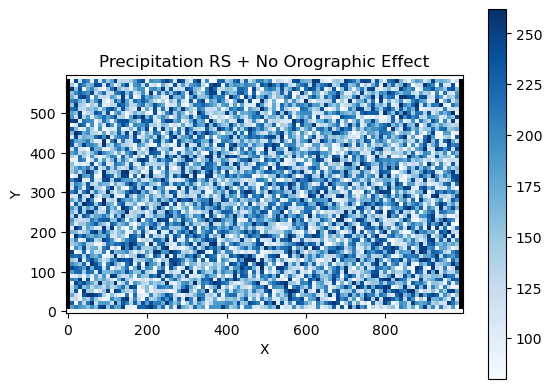

In [24]:
# Plot Precipitation
imshow_grid(mg2,"water__unit_flux_in", cmap="Blues", plot_name = "Precipitation RS + No Orographic Effect")

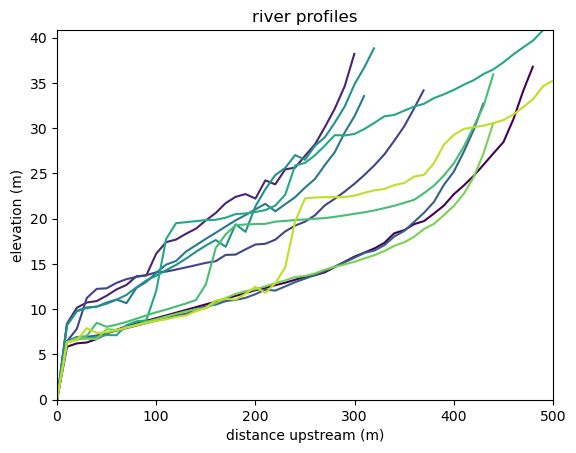

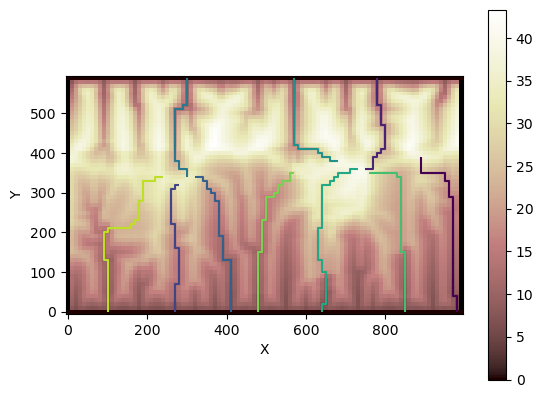

In [25]:
dxy=10

prf = ChannelProfiler(
mg,
number_of_watersheds=10,
main_channel_only=True,
minimum_channel_threshold=dxy**2,
)
prf.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
prf.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
prf.plot_profiles_in_map_view()

# 4: Influence of Rainshadow WITH Orographic effect

 ### Runs grid WITH orographic effect:

In [26]:
## Create a Raster Grid
mg2 = RasterModelGrid((60, 100), xy_spacing=10)
mg2.set_closed_boundaries_at_grid_edges(True, False, True, False)

# add a topographic__elevation field with noise
np.random.seed(0)
z = mg2.add_zeros("topographic__elevation", at="node")
z[mg2.core_nodes] += 0 + np.random.rand(mg2.core_nodes.size)*5

In [27]:
## Stream Power Eroder Component

# Fastscape Eroder Model Params
dt = 100 # timestep
P0 = 80
a = 1/2.2
U = 0.05 # uplift
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

# Generate water flux field WITH Orographic effect
mg2.add_zeros("water__unit_flux_in",at="node") 
mg2.at_node["water__unit_flux_in"][:] = P0 + a*P0*z 

# Flow Accumulator Model Params
fr3 = FlowAccumulator(mg2, depression_finder="DepressionFinderAndRouter", routing="D4")
sp3 = StreamPowerEroder(
    mg2,
    K_sp=0.0005,
    discharge_field="surface_water__discharge")

## Linear Diffuser Model Params
D = (P0 + a*P0*z) *0.001
ld = LinearDiffuser(mg2, linear_diffusivity=D)

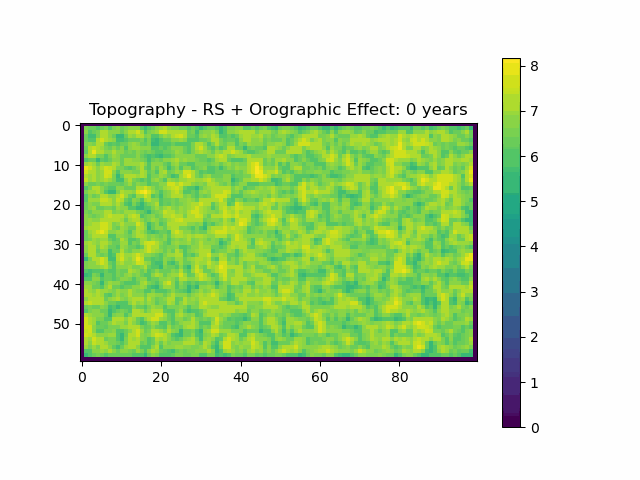

In [28]:
# Run model and Generate GIF
if not os.path.exists('save_fig'):
    os.makedirs('save_fig')
else:
    [os.remove(os.path.join('save_fig',f)) for f in os.listdir('save_fig') if f.endswith('.png')]

frames = []
for i in range(30):
    D = (P0 + a*P0*z)*0.0005
    fr3.run_one_step() # Flow Accumulator
    sp3.run_one_step(dt) # StreamPower FastScape Eroder
    ld.run_one_step(dt) # Linear Diffuser
    z[mg2.core_nodes] += U * dt
    mg2.at_node["water__unit_flux_in"][mg2.y_of_node>=2+mg2.y_of_node[z==max(z)]]=P0/2
    D[mg2.y_of_node>=2+mg2.y_of_node[z==max(z)]] = (P0/2)*0.001*np.ones(len( D[mg2.y_of_node>=10+mg2.y_of_node[z==max(z)]]))
    mg2.at_node["water__unit_flux_in"][mg2.y_of_node<10+mg2.y_of_node[z==max(z)]]=P0 + a*P0*z[mg2.y_of_node<10+mg2.y_of_node[z==max(z)]]
    
    frame = mg2.at_node["topographic__elevation"][:].reshape(mg2.shape)
    plt.imshow(frame)
    plt.colorbar()
    plt.title("Topography - RS + Orographic Effect: "+str(dt*i)+" years")
    plt.savefig(f'save_fig/{i}.png')
    plt.close()
    frames.append(Image.open(f'save_fig/{i}.png')) 
    
frames[0].save('Topo_Oro_RS.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

gif_path = 'Topo_Oro_RS.gif'
display(Img(filename=gif_path))

### Precipitation plot

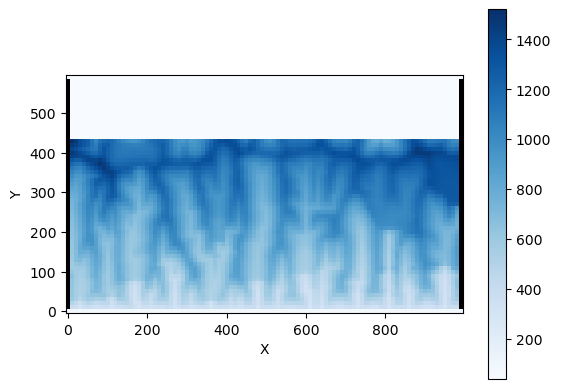

In [29]:
# Plot Precipitation -- Orographic Effect + Rainshadow
imshow_grid(mg2,"water__unit_flux_in", cmap="Blues")

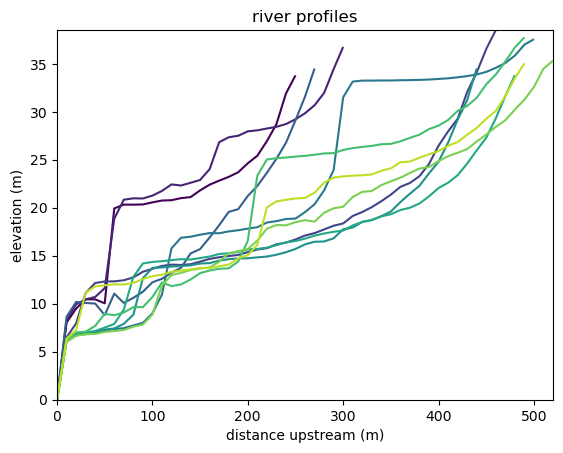

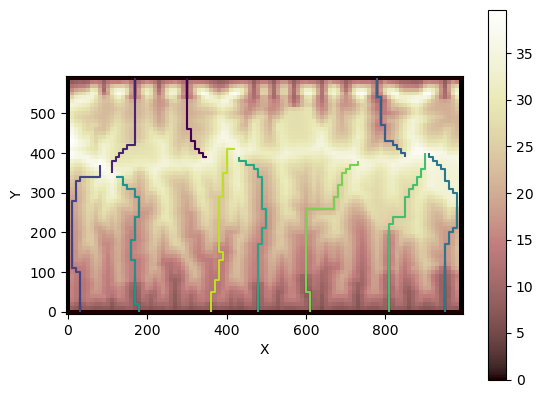

In [30]:
dxy=10

prf = ChannelProfiler(
mg2,
number_of_watersheds=10,
main_channel_only=True,
minimum_channel_threshold=dxy**2,
)
prf.run_one_step()
plt.figure(1)
#title_text = f"$K_{{sp}}$={K_sp}; ={total_time} yr; ={dxy} m"
prf.plot_profiles(xlabel="distance upstream (m)", ylabel="elevation (m)", title='river profiles')

plt.figure(2)
prf.plot_profiles_in_map_view()